## Step1: Import relevant libraries and dataset

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve,roc_auc_score

In [37]:
df=pd.read_csv("Fraud.csv")

## Step2: Data exploration and visualization

In [13]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [14]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [16]:
df.duplicated().sum()

0

In [ ]:
df.type.value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

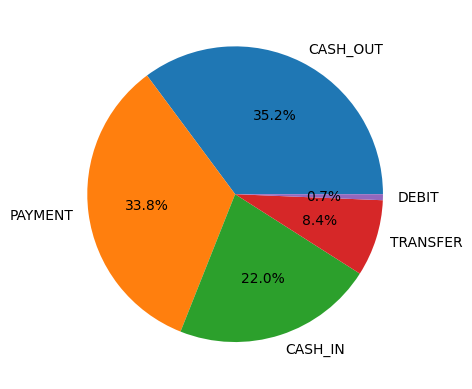

In [ ]:
plt.pie(df["type"].value_counts(), labels=df["type"].value_counts().index,autopct='%1.1f%%')
plt.show()

In [ ]:
df["isFraud"].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

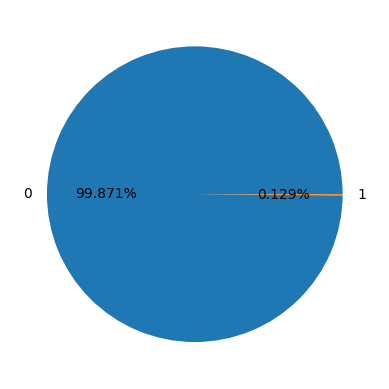

In [ ]:
plt.pie(df["isFraud"].value_counts(),labels=df["isFraud"].unique(),autopct='%1.3f%%')
plt.show()

our dataset is in a proportion of 99.871:0.129 for negative:positive class which is highly imbalanced

## Step3: Data Wrangling and Feature Engineering

In [39]:
df["payerdebited"]=df["oldbalanceOrg"]-df["newbalanceOrig"] #amount debited from payer's account
df["recievercredited"]=df["newbalanceDest"]-df["oldbalanceDest"] #amount credited to reciever's account
df["payer_type"]=[i[0:1] for i in df["nameOrig"]] # is the payer a merchant (M) or customer (C)?
df["reciever_type"]=[i[0:1] for i in df["nameDest"]] # is the reciever a merchant (M) or customer (C)?

In [ ]:
df["payer_type"].unique()

array(['C'], dtype=object)

there's only one type of payer: customer. So, it will not affect the performance of model 

In [ ]:
df["reciever_type"].unique()

array(['M', 'C'], dtype=object)

In [ ]:
df.reciever_type.value_counts()

reciever_type
C    4211125
M    2151495
Name: count, dtype: int64

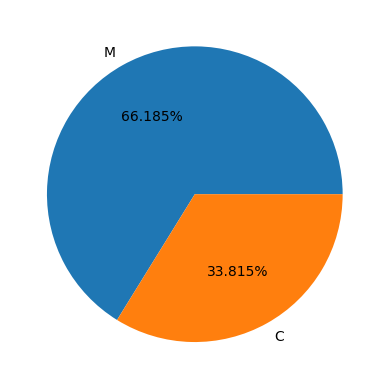

In [ ]:
plt.pie(df["reciever_type"].value_counts(),labels=df["reciever_type"].unique(),autopct='%1.3f%%')
plt.show()

In [ ]:
df.head()

,step,type,amount,isFraud,isFlaggedFraud,payerdebited,recievercredited,reciever_type
0,1,PAYMENT,9839.64,0,0,9839.64,0.0,M
1,1,PAYMENT,1864.28,0,0,1864.28,0.0,M
2,1,TRANSFER,181.00,1,0,181.00,0.0,C
3,1,CASH_OUT,181.00,1,0,181.00,-21182.0,C
4,1,PAYMENT,11668.14,0,0,11668.14,0.0,M


In [40]:
cat_cols=[col for col in df.columns if df[col].dtype=="object"]
encoder=LabelEncoder()
encoded_df=df.copy()
for col in cat_cols:
    encoded_df[col]=encoder.fit_transform(df[col])

**correlatoin matrix will help us find out features which show multicollinearity**

<Axes: >

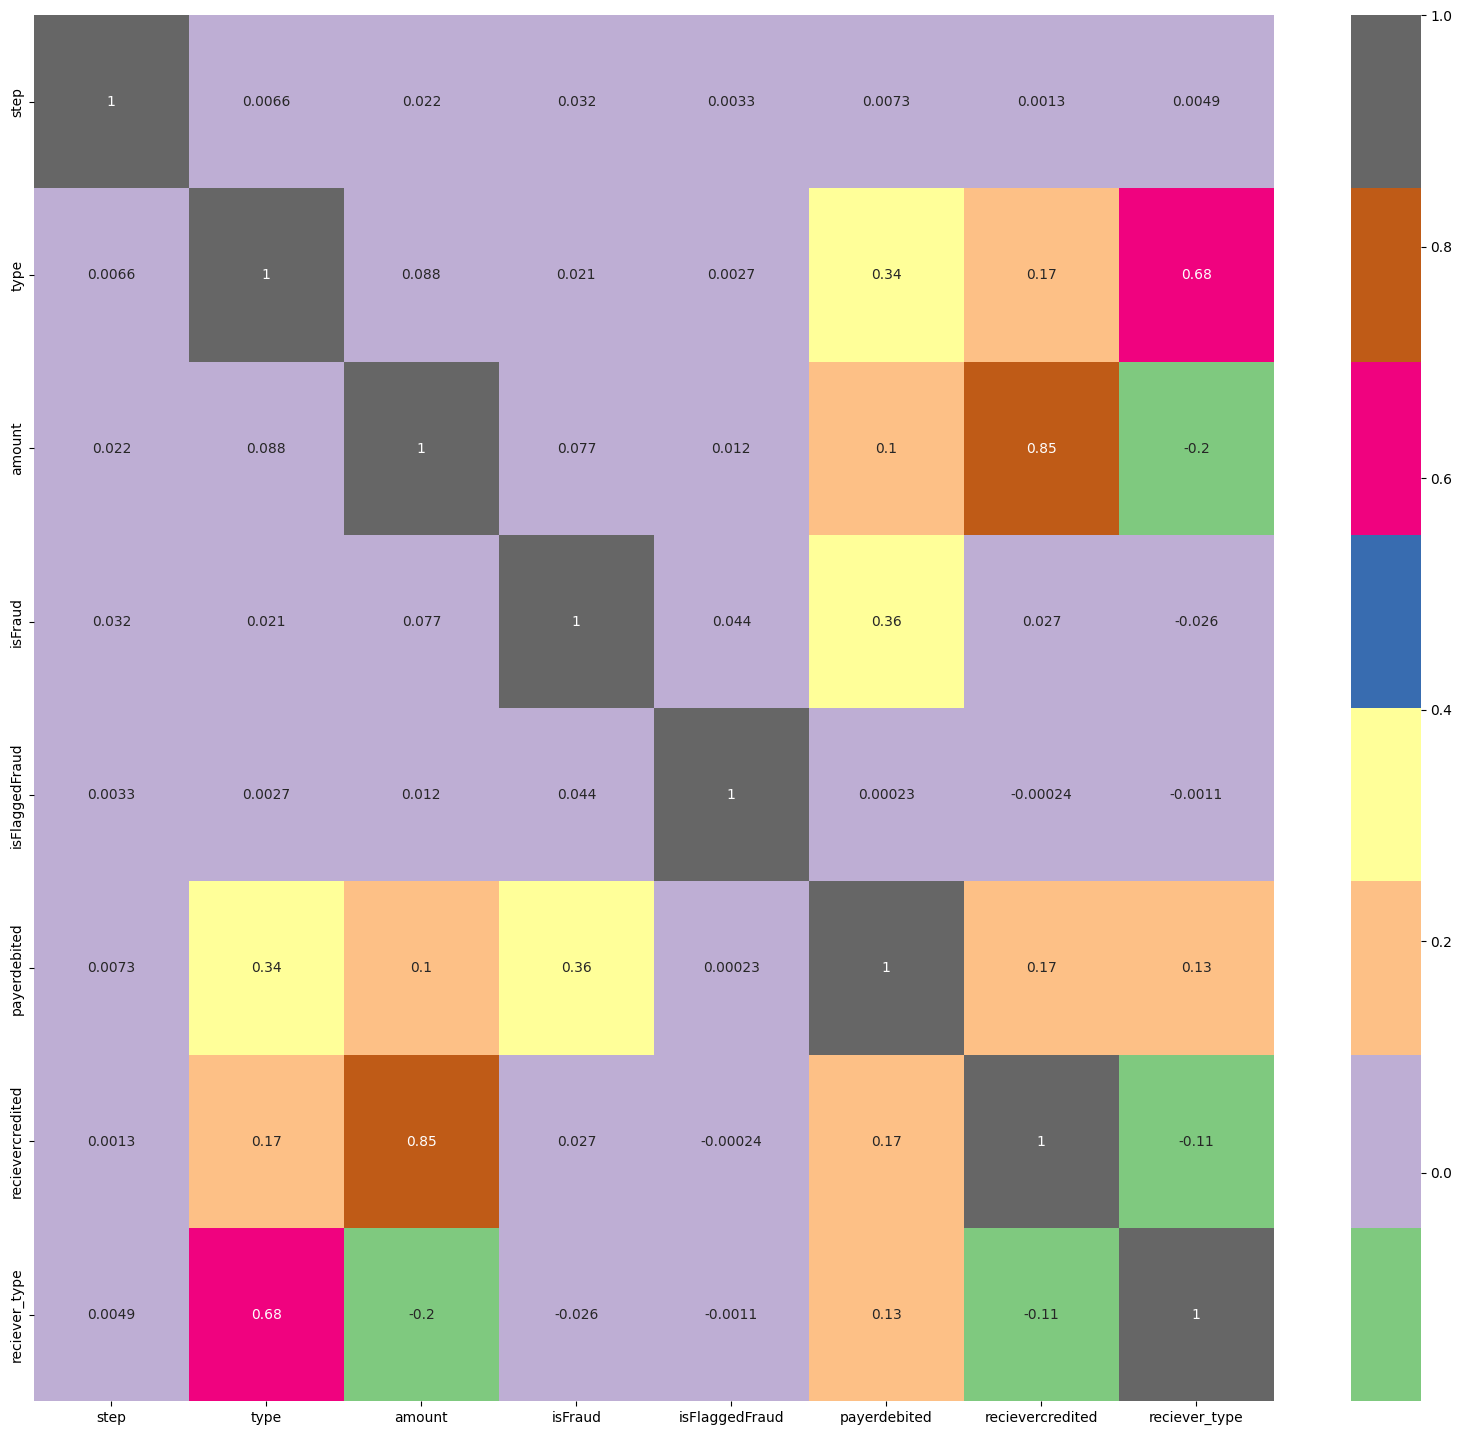

In [ ]:
plt.figure(figsize=(20,18))
corr = encoded_df.corr()
sns.heatmap(corr, annot = True, cmap="Accent")

Since "recievercredited" and "amount" show multicollinearity, we will remove one of them to avoid overfitting

In [41]:
todrop=["nameDest",
        "nameOrig",
        "oldbalanceOrg",
        "newbalanceOrig",
        "newbalanceDest",
        "oldbalanceDest",
        "isFlaggedFraud",
        "payer_type", #this is a zero-variance feature
        "recievercredited" #this feature is highly correlated to amount
        ]
encoded_df.drop(columns=todrop,inplace=True)

**counting outliers in the feature vector**

In [44]:
def outlier_count(data):
    Q1=data.quantile(.25)
    Q3=data.quantile(.75)
    IQR=Q3-Q1
    upwhisk=Q3+(IQR*1.5)
    lowhisk=Q1-(IQR*1.5)
    outlier_count=0
    for i in range(len(data)):
        if data[i]>upwhisk or data[i]<lowhisk:
            outlier_count=+1
    return outlier_count
outliers=0
columns=['step', 'type', 'amount', 'payerdebited', 'reciever_type']
for col in columns:
    outliers+=outlier_count(x[col])
print(f'No of Outliers:{outliers}')

No of Outliers:3


no of outliers <<<< number of rows in dataset. Therefore, no need of Cappping, trimming or imputing outliers

## Step4: Data modeling

In [45]:
x=encoded_df.drop(columns="isFraud") #independent variables

In [46]:
x.columns

Index(['step', 'type', 'amount', 'payerdebited', 'reciever_type'], dtype='object')

The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200,000 in a single transaction.

In [47]:
y = pd.Series([
    1 if encoded_df.loc[i, "amount"] > 200000 else encoded_df.loc[i, "isFraud"] for i in range(len(encoded_df))
    ]) # dependent variable

**splitting the dataset into training and validation sets**

In [48]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [49]:
forest=RandomForestClassifier(n_estimators=15,class_weight='balanced',criterion='entropy',random_state=42)
forest.fit(x_train,y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=15, random_state=42)

In [50]:
def illegal_transac(amount, model_prediction):
    if amount > 200000:
        return 1  # Fraud
    else:
        return model_prediction
y_hat=[illegal_transac(amount, pred) for amount, pred in zip(x_test['amount'], forest.predict(x_test))]

## Step5: Model Evaluation

In [51]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    936581
           1       1.00      1.00      1.00    335943

    accuracy                           1.00   1272524
   macro avg       1.00      1.00      1.00   1272524
weighted avg       1.00      1.00      1.00   1272524



Looks like the model is performaning perfectly on our validation set of (20% of 6,362,620=1,272,524) data instances 

**Confusion Matrix**

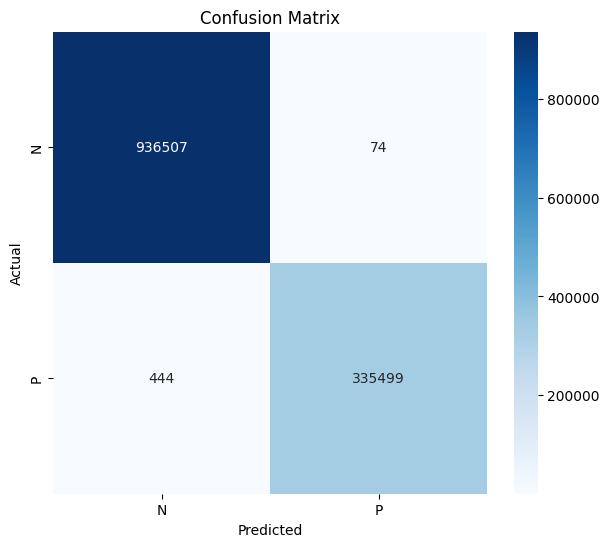

In [52]:
con_mat=confusion_matrix(y_test, y_hat)
class_names = 'NP'
plt.figure(figsize=(7,6))
sns.heatmap(con_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

**ROC (Reciever Operating Characteristic) curve**

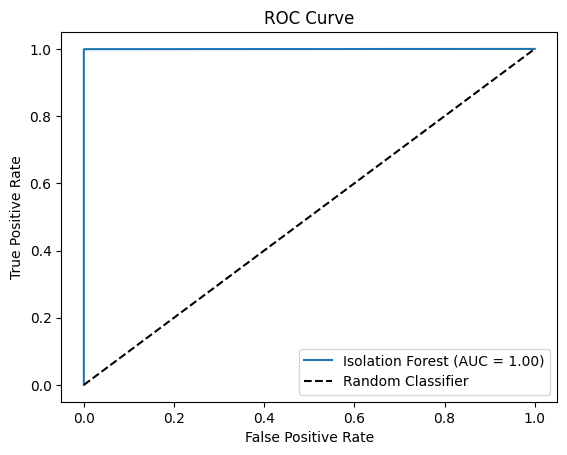

In [53]:
y_probs = forest.predict_proba(x_test)[:, 1]  # Probability estimates for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)
plt.figure()
plt.plot(fpr, tpr, label='Isolation Forest (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()